In [ ]:
import torch
import torch.nn as nn

In [ ]:
import torch.optim as optim
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dset
from torch.utils.data import DataLoader, ConcatDataset
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
FOLDERPATH = 'Colab\ Notebooks/Poster'
%cd drive/MyDrive/$FOLDERPATH

/content/drive/MyDrive/Colab Notebooks/Poster


In [ ]:
# Check device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(f'Device: {device}')

Device: cuda


## Build Model

In [ ]:
# Build Block
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=stride,padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.functional.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

        out += identity
        out = nn.functional.relu(out)
        return out

In [ ]:
# Build ResNet
class ResNet(nn.Module):  # [3, 4, 6, 3]
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool_ = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)
        out_max = self.maxpool(out)  # Normal ResNet goes with a maxpool
        out_avg = self.avgpool_(out)  # Change maxpool to avgpool
        out = (out_avg + out_max)/2  # Average of both pooling

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

In [ ]:
# Define ResNet 50/101/152
def ResNet10(img_channels=3, num_classes=1000):
    return ResNet(block, [1, 1, 1, 1], img_channels, num_classes)

def ResNet18(img_channels=3, num_classes=1000, dropout_prob=0.5):
    return ResNet(block, [2, 2, 2, 2], img_channels, num_classes)

def ResNet50(img_channels=3, num_classes=1000, dropout_prob=0.5):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels=3, num_classes=1000, dropout_prob=0.5):
    return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels=3, num_classes=1000, dropout_prob=0.5):
    return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

## Data Pre-Processing

In [ ]:
# Hyper Parameter
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4

PRINT_EVERY = 100

In [ ]:
# Fix the random seed to compare the result
def set_seed(seed=42, loader=None):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  try:
    loader.sampler.generator.manual_seed(seed)
  except AttributeError:
    pass

set_seed()

In [ ]:
# Data pre-processing
transform_0 = T.Compose([
    T.Resize((300,300)),
    T.RandomCrop((224,224)),
    T.ToTensor()
])
transform_1 = T.Compose([
    T.RandomRotation(degrees=45),
    T.Resize((300,300)),
    T.RandomCrop((224,224)),
    T.ToTensor()
])

transform_2 = T.Compose([
    T.RandomRotation(degrees=45),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.5),
    T.Resize((300,300)),
    T.RandomCrop((224,224)),
    T.ToTensor()
])
transform_test = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
# generate training data
train_data_0 = dset.ImageFolder('Dataset/2_classes/train', transform=transform)
train_data_1 = dset.ImageFolder('new_test', transform=transform)
train_data = ConcatDataset([train_data_0, train_data_1])

In [ ]:
# Load Data
# 0: portrait  1: SD
train_data = ConcatDataset([train_data_0, train_data_1, train_data_2])
val_data = dset.ImageFolder('Dataset/2_classes/val', transform=transform_test)
test_data = dset.ImageFolder('Dataset/2_classes/test', transform=transform_test)

In [ ]:
# Check data dimension
print(train_data[0][0].shape)
print(val_data[0][1])

torch.Size([3, 224, 224])
0


In [ ]:
NUM_TRAIN = len(train_data)
NUM_VAL = len(val_data)
NUM_TEST = len(test_data)
print('Number of training:', NUM_TRAIN)
print('Number of validation:', NUM_VAL)
print('Numver of test:', NUM_TEST)

Number of training: 2400
Number of validation: 80
Numver of test: 80


In [ ]:
# Set seed for DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
# Create Mini-Batch
mini_trains = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
mini_vals = DataLoader(val_data, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, generator=g)
mini_tests = DataLoader(test_data, batch_size=BATCH_SIZE)

## Build model & Training

In [ ]:
# # Build model
# resnet = ResNet18(3, 2, 0.3)
# num_flatten = resnet.fc.in_features
# resnet.fc = nn.Linear(num_flatten, 2)
# model = resnet.to(device)

In [ ]:
# Load model and trained weights
# PATH = 'resnet18_avgpool_1e3_100.pth'

resnet = ResNet10()
num_flatten = resnet.fc.in_features
resnet.fc = nn.Linear(num_flatten, 2)

# resnet.load_state_dict(torch.load(PATH))
model = resnet.to(device)

In [ ]:
# Define loss function & optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Training procedure
def train(mini_trains, model, NUM_EPOCHES, device):
    loss_history = []
    epoch_ticks = []
    for epoch in range(NUM_EPOCHES):
        for count, (x, y) in enumerate(mini_trains):
            # Turn on training mode
            model.train()
            # Move data to device
            x = x.to(device)
            y = y.to(device)
            # ForwardProp
            scores = model(x)
            # Calculate loss
            loss = loss_function(scores, y)
            loss_history.append(loss.item())

            if count % PRINT_EVERY == 0:
                print(f'[Epoch {epoch+1}] Training loss', loss.item())
                validation(mini_vals, epoch, model, device)

            # Clear the previous gradients
            optimizer.zero_grad()
            # Get the gradients
            loss.backward()
            # Update the weights
            optimizer.step()
        epoch_ticks.append(len(loss_history))
        print('-'*50)
    plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss')
    plt.xlabel('Iters')
    plt.ylabel('Loss')
    plt.title('Loss vs Mini-batch Iterations')
    plt.legend()

    # show epoch
    for i, tick in enumerate(epoch_ticks):
        plt.axvline(x=tick, color='red', linestyle='--', label=f'Epoch {i + 1}' if i == 0 else None)

    plt.show()

In [ ]:
# Validation Procedure
def validation(mini_vals, epoch, model, device):
  # Turn on val mode
  model.eval()
  with torch.no_grad():
    acc_acount = 0
    for x, y in mini_vals:
      # move data to device
      x = x.to(device)
      y = y.to(device)
      # Forward Prop
      scores = model(x)
      # Calculate accuracy
      predictions = scores.max(1)[1]
      acc = predictions.eq(y).sum().item()
      acc_acount += acc
    print(f'[Epoch {epoch+1}] Accuracy:', acc_acount/NUM_VAL)

[Epoch 1] Training loss 0.7596797347068787
[Epoch 1] Accuracy: 0.5
[Epoch 1] Training loss 0.7085124850273132
[Epoch 1] Accuracy: 0.6375
--------------------------------------------------
[Epoch 2] Training loss 0.5630892515182495
[Epoch 2] Accuracy: 0.6625
[Epoch 2] Training loss 0.5761474967002869
[Epoch 2] Accuracy: 0.6375
--------------------------------------------------
[Epoch 3] Training loss 0.5491592884063721
[Epoch 3] Accuracy: 0.6375
[Epoch 3] Training loss 0.4162265658378601
[Epoch 3] Accuracy: 0.725
--------------------------------------------------
[Epoch 4] Training loss 0.48389577865600586
[Epoch 4] Accuracy: 0.675
[Epoch 4] Training loss 0.3793000876903534
[Epoch 4] Accuracy: 0.7125
--------------------------------------------------
[Epoch 5] Training loss 0.38372424244880676
[Epoch 5] Accuracy: 0.75
[Epoch 5] Training loss 0.4612850546836853
[Epoch 5] Accuracy: 0.7375
--------------------------------------------------
[Epoch 6] Training loss 0.6706741452217102
[Epoch 

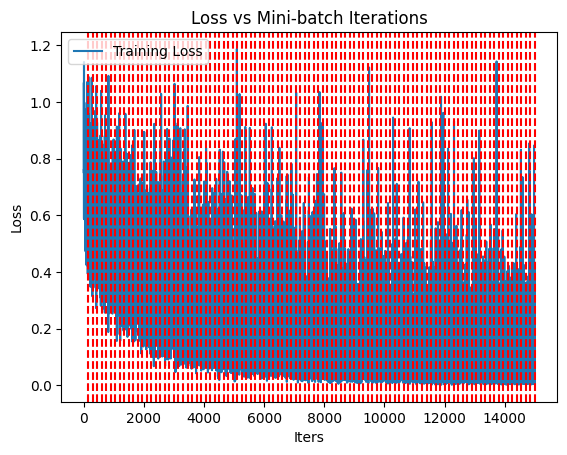

In [ ]:
# Training
train(mini_trains, model, NUM_EPOCHS, device)

In [ ]:
# Test score procedure
def test(mini_tests, model, device):
  # Use val mode to test
  model.eval()
  with torch.no_grad():
    acc_count = 0
    for x, y in mini_tests:
      # move data to device
      x = x.to(device)
      y = y.to(device)
      # Last Forward Prop
      score_test = model(x)
      # Calculate Accuracy
      predictions = score_test.max(1)[1]
      acc = predictions.eq(y).sum().item()
      acc_count += acc
    print(f'[Final] Test Accuracy:', acc_count/NUM_TEST)

In [ ]:
test(mini_tests, model, device)

[Final] Test Accuracy: 0.85


In [ ]:
# save trained weights
# torch.save(resnet.state_dict(), 'resnet50_with_avgpool_0913_weights.pth')

## Test with milestone data

In [ ]:
# # Load model and trained weights
# PATH = 'resnet50_with_avgpool_0913_weights.pth'

# model = models.resnet50(pretrained=True)
# num_flatten = model.fc.in_features
# model.fc = nn.Linear(num_flatten, 4)

# model.load_state_dict(torch.load(PATH))
# model = model.to(device)

In [ ]:
# Load test data
new_test_data = dset.ImageFolder('milestone', transform=transform_test)
NUM_NEW_TEST = len(new_test_data)
print('Number of new test:', NUM_NEW_TEST)
mini_new_tests = DataLoader(new_test_data, batch_size=1)

Number of new test: 400


In [ ]:
# Test score procedure
def milestone_test(mini_tests, model, device):
    # Use eval mode to test
    model.eval()
    valid_classes = [0, 2]  # Classes Filter
    with torch.no_grad():
        acc_count = 0
        total_samples = 0
        for x, y in mini_tests:
            # move data to device
            x = x.to(device)
            y = y.to(device)

            # Last Forward Prop
            score_test = model(x)

            # Calculate predictions
            predictions = score_test.max(1)[1]

            # # Filter out predictions that are not in valid_classes
            # filtered_predictions = [p.item() for p in predictions if p.item() in valid_classes]
            # filtered_labels = [label.item() for label in y if label.item() in valid_classes]

            # # Calculate Accuracy
            # correct_predictions = sum([pred == label for pred, label in zip(filtered_predictions, filtered_labels)])
            # acc_count += correct_predictions
            # total_samples += len(filtered_labels)  # Update with the number of valid samples

            # Calculate Accuracy
            acc = predictions.eq(y).sum().item()
            acc_count += acc

        print(f'[Final] Test Accuracy:', acc_count / NUM_NEW_TEST)

In [ ]:
milestone_test(mini_new_tests, model, device)

In [ ]:
# save trained weights
torch.save(resnet.state_dict(), 'resnet10_max+avgpool_1e4_100_2classes_0918.pth')